<a href="https://colab.research.google.com/github/myeongsingh/TRAFFIC-VIOLATION-DETECTION-/blob/main/YOLOv8n_Rider_with_without_Helmet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'rider-with-helmet-without-helmet-number-plate:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4527644%2F7760820%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240825%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240825T224354Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D44c7a94fc86334c0e43b9ad77d0cc678250e090646abe013606963a6518570cb1f054884964a5f2f11d2796b9c661c7f53f6dc76e1ed5641a0f235952a235042d940a8c144d3319541403181475643e4cc5f7705919e355446dfbb48f05da314e66b8b3b07e966205af0c74367aded1b239eea0cfae27c35c18722d941e87cd57bd3d8195a3777fed82474c92f08df3344e2c6f94a2ee28ca59d3f645c9d851291fc1bdab80c347a82a7015afdf800ffb24244a66cfd4fe7612dc7125cf6a4891958145c905d9063c2e6874c763d371fdd579c8bb3435eb6381a4d37ba3ad976522b16a712bd51ccb7746c19f7c4cb7a1c8fffc589e646287f94e45b134a84b5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 78254888 bytes downloaded
Downloaded and uncompressed: rider-with-helmet-without-helmet-number-plate
Data source import complete.


# Basic Learning About YOLO Dataset

### What does YOLO dataset format look like?
```
 data_directory/
    ├── images/
    │   ├── image1.jpg
    │   ├── image2.jpg
    │   ├── ...
    │   └── imageN.jpg
    └── labels/
        ├── image1.txt
        ├── image2.txt
        ├── ...
        └── imageN.txt


```


### What does label data look like?
```
2 0.561805 0.503788 0.865275 0.983333
0 0.569729 0.083333 0.310611 0.139394
3 0.477813 0.838636 0.329628 0.089394
```

- a row --> an object detecting in this image
- the meaning of each element within each row:
    - label
    - the bounding box middle point x
    - the bounding box middle point y
    - the bounding box width
    - the bounding box heigth




# Check GPU Setting
Remember to click Accelerator to activate GPU for the model training, and the you may use `nvydia-smi` to check current status of GPU

In [ ]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# Install Needed Packages

In [ ]:
# install packages used in YOLO model
! pip install ultralytics

In [ ]:
# check model
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.8/107.7 GB disk)


# Data Analytics - EDA
Let's take a look at the overall data pattern for further model training

### Get Data Size, Class Count

In [ ]:
from glob import glob
from itertools import chain
from collections import Counter
from pprint import pprint

id2class_map = {
    '0': 'with helmet',
    '1': 'without helmet',
    '2': 'rider',
    '3': 'number_plate'
}
main_path = "/kaggle/input/rider-with-helmet-without-helmet-number-plate"

def print_data_size(folder_type):
    data_size = len(glob(f'{main_path}/{folder_type}/labels/*.txt'))
    print(f'{folder_type} data count: {data_size}')

def print_class_count(folder_type):
    class_list = []
    for file in glob(f'{main_path}/{folder_type}/labels/*.txt'):
        class_list.append([row.split()[0] for row in open(file, "r")])
    counter = Counter(list(chain(*class_list)))
    print(f'-- data class count')
    pprint({f'{k}. {id2class_map[k]}':v for k, v in counter.items()})
    print()

print_data_size('train')
print_class_count('train')
print_data_size('val')
print_class_count('val')

train data count: 104
-- data class count
{'0. with helmet': 64,
 '1. without helmet': 93,
 '2. rider': 120,
 '3. number_plate': 116}

val data count: 20
-- data class count
{'0. with helmet': 13,
 '1. without helmet': 15,
 '2. rider': 23,
 '3. number_plate': 22}



### Plot Training Images

In [ ]:
# plot training images
import os
import cv2
from matplotlib import pyplot as plt

main_path = f"/kaggle/input/rider-with-helmet-without-helmet-number-plate"

def get_bbox_and_label(image_name, data_type='train', main_path=main_path):
    ''' get bbox and label information from label txt files '''

    # read file from path
    lbl_path = os.path.join(main_path, data_type, 'labels', f'{image_name}.txt')
    with open(lbl_path, 'r') as f:
        lines = f.readlines()

    # extract bboxes and labels from the label file
    bboxes = [
        [float(n) for n in line.split()[1:]]
        for line in lines
    ]
    labels = [id2class_map[line.split()[0]] for line in lines]

    return bboxes, labels

def load_image(image_name, data_type='train', main_path=main_path):
    img_path = os.path.join(main_path, data_type, 'images', f'{image_name}.jpg')
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_bbox_coordinates(img, bbox):
    # reference
    # https://medium.com/@miramnair/yolov7-calculating-the-bounding-box-coordinates-8bab54b97924

    img_height, img_width, _ = img.shape
    x_center, y_center, bbox_width, bbox_height = bbox

    # calculate the coordinates of the bounding box
    x_center_pixel = x_center * img_width
    y_center_pixel = y_center * img_height
    half_width = bbox_width * img_width / 2
    half_height = bbox_height * img_height / 2

    x_min = int(x_center_pixel - half_width)
    y_min = int(y_center_pixel - half_height)
    x_max = int(x_center_pixel + half_width)
    y_max = int(y_center_pixel + half_height)

    return x_min, y_min, x_max, y_max

class2color_map = {
    'with helmet': (0,255,128),
    'without helmet': (255,51,51),
    'rider': (51,255,255),
    'number_plate': (224,102,255)
}

def plot_image(image_name, data_type='train', class2color_map=class2color_map):
    img = load_image(image_name=image_name, data_type=data_type)
    bboxes, labels = get_bbox_and_label(image_name=image_name, data_type=data_type)
    for bbox, label in zip(bboxes, labels):

        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = get_bbox_coordinates(img, bbox)

        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 0.6,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

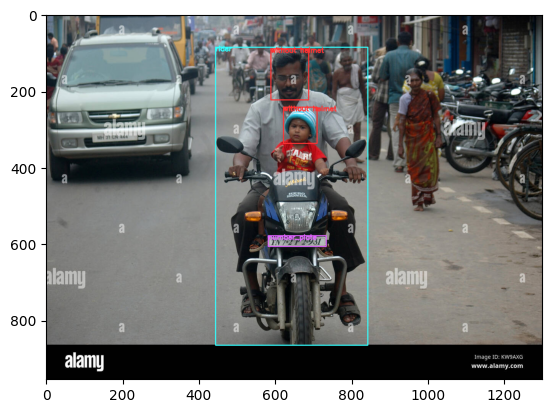

In [ ]:
plot_image(image_name='new100')

# Load YOLO8 Model

In [ ]:
from ultralytics import YOLO

# Load a COCO-pretrained YOLOv8n model
model = YOLO('yolov8n.pt')

# Display model information (optional)
model.info()

100%|██████████| 6.25M/6.25M [00:00<00:00, 125MB/s]


YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

# Set yaml & Model Training

In [ ]:
import yaml

# read the content of coco128.yaml
with open(os.path.join(main_path, 'coco128.yaml'), 'r') as file:
    print(file.read())

train: /train/images
val: /val/images

nc: 4

names: ["with helmet", "without helmet", "rider", "number plate"]


In [ ]:
# creata the yaml based on coco128 for model training
data = {
    'train': '/kaggle/input/rider-with-helmet-without-helmet-number-plate/train',
    'val': '/kaggle/input/rider-with-helmet-without-helmet-number-plate/val',
    'nc': 4,
    'names': [
        'with helmet',
        'without helmet',
        'rider',
        'number plate'
    ]
}

with open('/kaggle/working/data.yaml', 'w') as file:
    yaml.dump(data, file)

# check the content of data.yaml
with open('/kaggle/working/data.yaml', 'r') as file:
    print(file.read())

names:
- with helmet
- without helmet
- rider
- number plate
nc: 4
train: /kaggle/input/rider-with-helmet-without-helmet-number-plate/train
val: /kaggle/input/rider-with-helmet-without-helmet-number-plate/val



In [ ]:
# disable wandb
os.environ['WANDB_MODE'] = "disabled"


# command to train the YOLOv8 model
model.train(
    data='/kaggle/working/data.yaml',
    epochs=10,
    workers=1,
    batch=8,
)

Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=1, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxe

train: Scanning /kaggle/input/rider-with-helmet-without-helmet-number-plate/train/labels.cache... 102 images, 0 backgrounds, 2 corrupt: 100%|██████████| 104/104 [00:00<?, ?it/s]

train: WARNING ⚠️ /kaggle/input/rider-with-helmet-without-helmet-number-plate/train/images/new128.jpg: ignoring corrupt image/label: cannot identify image file '/kaggle/input/rider-with-helmet-without-helmet-number-plate/train/images/new128.jpg'
train: WARNING ⚠️ /kaggle/input/rider-with-helmet-without-helmet-number-plate/train/images/new3.jpg: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'tiff', 'bmp', 'mpo', 'webp', 'pfm', 'tif', 'dng', 'jpg', 'png', 'jpeg'}
videos: {'webm', 'mkv', 'avi', 'ts', 'mpeg', 'mov', 'asf', 'm4v', 'mp4', 'mpg', 'wmv', 'gif'}
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/input/rider-with-helmet-without-helmet-number-plate/val/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]

Plotting labels to runs/detect/train2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G       1.09      3.703      1.286         29        640: 100%|██████████| 13/13 [01:36<00:00,  7.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.75s/it]

                   all         20         73     0.0177      0.361      0.233      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G     0.8738      2.417      1.102         22        640: 100%|██████████| 13/13 [01:28<00:00,  6.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.90s/it]

                   all         20         73     0.0258      0.402      0.229      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      0.812      1.661      1.063         27        640: 100%|██████████| 13/13 [01:29<00:00,  6.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.99s/it]

                   all         20         73      0.569      0.731      0.671      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G     0.8341      1.494      1.029         20        640: 100%|██████████| 13/13 [01:33<00:00,  7.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.87s/it]

                   all         20         73          1     0.0992      0.797      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G     0.8321      1.377       1.02         21        640: 100%|██████████| 13/13 [01:30<00:00,  6.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.18s/it]

                   all         20         73      0.985      0.324      0.869      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G     0.7884      1.269      1.006         25        640: 100%|██████████| 13/13 [01:33<00:00,  7.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]

                   all         20         73      0.879      0.688      0.907      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G     0.7466      1.158     0.9982         21        640: 100%|██████████| 13/13 [01:27<00:00,  6.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.71s/it]

                   all         20         73      0.875      0.812      0.917      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G     0.7139      1.164     0.9663         23        640: 100%|██████████| 13/13 [01:30<00:00,  6.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.28s/it]

                   all         20         73      0.887      0.816      0.924      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G     0.7097      1.072     0.9729         23        640: 100%|██████████| 13/13 [01:27<00:00,  6.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.90s/it]

                   all         20         73      0.886      0.879      0.937      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G     0.7145      1.073     0.9589         18        640: 100%|██████████| 13/13 [01:30<00:00,  6.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]

                   all         20         73       0.88      0.914      0.942      0.783



10 epochs completed in 0.273 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.2.82 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.91s/it]


                   all         20         73       0.88      0.914      0.941      0.781
           with helmet         12         13          1      0.889      0.995       0.82
        without helmet         10         15       0.72      0.857      0.865      0.692
                 rider         20         23      0.825      0.957      0.944      0.812
          number plate         20         22      0.977      0.955      0.962      0.801
Speed: 2.6ms preprocess, 340.3ms inference, 0.0ms loss, 12.5ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bcb3697f6d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

# Check Val Detecting Image
We may check the detection result of our validation images.

In [ ]:
# select the best model for checking prediction plot
# the model is saved in best.pt directly after training
model = YOLO('/content/runs/detect/train2/weights/best.pt')

In [ ]:
# use results from `model.predict()` for plotting
def plot_pred_image(image_name, id2class_map=id2class_map, class2color_map=class2color_map):
    image_path = os.path.join(main_path, 'val', 'images', f'{image_name}.jpg')

    # get plot elements (bbox, labels) from `predict()` results
    results = model.predict(image_path)
    r = results[0]
    img = r.orig_img
    bboxes = r.boxes.xyxy.tolist()
    labels = [id2class_map[str(int(c))] for c in r.boxes.cls.tolist()]
    for bbox, label in zip(bboxes, labels):
        # get bbox and label info
        color = class2color_map[label]
        x_min, y_min, x_max, y_max = [int(n) for n in bbox]

        # add bounding box with rectangle
        img = cv2.rectangle(img,(x_min,y_min),(x_max,y_max), color, 2)

        # add label info
        img = cv2.putText(
                img,
                label,
                (x_min, y_min + 10),
                fontFace = cv2.FONT_HERSHEY_SIMPLEX,
                fontScale = 1,
                color = color,
                thickness=2
            )
    plt.imshow(img)
    plt.show()

prediction ↓

image 1/1 /kaggle/input/rider-with-helmet-without-helmet-number-plate/val/images/new94.jpg: 608x640 1 with helmet, 1 rider, 1 number plate, 230.8ms
Speed: 5.1ms preprocess, 230.8ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


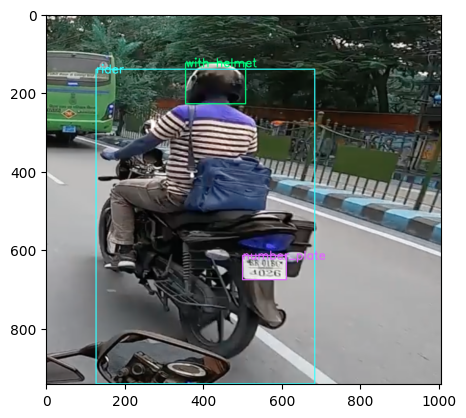

In [ ]:
image_name = 'new94'
print('prediction ↓')
plot_pred_image(image_name=image_name)
